# Project 2 report

In [45]:
# Imports
import numpy as np
import pandas as pd
import geopandas as geopd
import folium as fol
import seaborn as sns
import matplotlib.pyplot as plt

# Params
pd.set_option('display.max_columns', None)

# Q0: Basic EDA + Tidying

In [2]:
# Read in data
df = pd.read_csv('dft_rawcount_region_id_3.csv')

/usr/local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (11,12) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
df.head()

,count_point_id,direction_of_travel,year,count_date,hour,region_id,region_name,local_authority_id,local_authority_name,road_name,road_type,start_junction_road_name,end_junction_road_name,easting,northing,latitude,longitude,link_length_km,link_length_miles,pedal_cycles,two_wheeled_motor_vehicles,cars_and_taxis,buses_and_coaches,lgvs,hgvs_2_rigid_axle,hgvs_3_rigid_axle,hgvs_3_or_4_articulated_axle,hgvs_4_or_more_rigid_axle,hgvs_5_articulated_axle,hgvs_6_articulated_axle,all_hgvs,all_motor_vehicles
0,931907,N,2019,2019-06-17,18,3,Scotland,29,City of Edinburgh,U,Minor,NaN,NaN,318480,675750,55.967806,-3.30758,NaN,NaN,8,2,290,5,20,0,0,0,0,0,0,0,317
1,931907,S,2019,2019-06-17,13,3,Scotland,29,City of Edinburgh,U,Minor,NaN,NaN,318480,675750,55.967806,-3.30758,NaN,NaN,1,1,258,4,36,4,2,0,1,0,0,7,306
2,931907,N,2019,2019-06-17,9,3,Scotland,29,City of Edinburgh,U,Minor,NaN,NaN,318480,675750,55.967806,-3.30758,NaN,NaN,5,1,270,5,44,5,2,0,1,0,0,8,328
3,931907,S,2019,2019-06-17,12,3,Scotland,29,City of Edinburgh,U,Minor,NaN,NaN,318480,675750,55.967806,-3.30758,NaN,NaN,2,2,266,4,50,2,5,0,2,0,0,9,331
4,931907,S,2019,2019-06-17,10,3,Scotland,29,City of Edinburgh,U,Minor,NaN,NaN,318480,675750,55.967806,-3.30758,NaN,NaN,4,0,247,8,35,2,3,0,3,0,0,8,298


In [4]:
df.describe(include='all')

,count_point_id,direction_of_travel,year,count_date,hour,region_id,region_name,local_authority_id,local_authority_name,road_name,road_type,start_junction_road_name,end_junction_road_name,easting,northing,latitude,longitude,link_length_km,link_length_miles,pedal_cycles,two_wheeled_motor_vehicles,cars_and_taxis,buses_and_coaches,lgvs,hgvs_2_rigid_axle,hgvs_3_rigid_axle,hgvs_3_or_4_articulated_axle,hgvs_4_or_more_rigid_axle,hgvs_5_articulated_axle,hgvs_6_articulated_axle,all_hgvs,all_motor_vehicles
count,279480.000000,279480,279480.000000,279480,279480.000000,279480.0,279480,279480.000000,279480,279480,279480,129832,129832,279480.000000,2.794800e+05,279480.000000,279480.000000,130180.000000,130180.000000,279480.000000,279480.000000,279480.000000,279480.000000,279480.000000,279480.000000,279480.000000,279480.000000,279480.000000,279480.000000,279480.000000,279480.000000,279480.000000
unique,NaN,5,NaN,1870,NaN,NaN,1,NaN,32,495,2,1102,1098,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,S,NaN,2018-09-10,NaN,NaN,Scotland,NaN,Fife,U,Minor,LA Boundary,LA Boundary,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,73812,NaN,720,NaN,NaN,279480,NaN,18672,65220,149300,5092,6720,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,523774.702462,NaN,2009.839717,NaN,12.500114,3.0,NaN,36.467626,NaN,NaN,NaN,NaN,NaN,295346.349921,7.115550e+05,56.282931,-3.684153,5.114988,3.178153,0.949953,1.621043,289.582002,5.314599,45.802057,11.047005,1.907321,1.589624,1.884825,4.141266,4.335520,24.905560,367.225261
std,447914.220640,NaN,5.797134,NaN,3.452059,0.0,NaN,23.418558,NaN,NaN,NaN,NaN,NaN,56623.729924,9.782121e+04,0.879098,0.921907,6.102640,3.792216,2.648190,3.392475,473.267874,9.445987,84.355333,23.660169,4.486867,4.527732,5.186480,13.185730,14.198993,57.849017,602.689129
min,700.000000,NaN,2000.000000,NaN,7.000000,3.0,NaN,3.000000,NaN,NaN,NaN,NaN,NaN,70406.000000,5.390000e+05,54.721418,-7.443134,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,50763.000000,NaN,2005.000000,NaN,10.000000,3.0,NaN,30.000000,NaN,NaN,NaN,NaN,NaN,257914.000000,6.612000e+05,55.832609,-4.275173,1.300000,0.810000,0.000000,0.000000,32.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,43.000000
50%,811309.000000,NaN,2009.000000,NaN,13.000000,3.0,NaN,36.000000,NaN,NaN,NaN,NaN,NaN,291905.000000,6.752400e+05,55.973501,-3.743832,2.700000,1.680000,0.000000,0.000000,126.000000,2.000000,18.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,159.000000
75%,951133.000000,NaN,2015.000000,NaN,16.000000,3.0,NaN,44.000000,NaN,NaN,NaN,NaN,NaN,334930.000000,7.418300e+05,56.562551,-3.042314,6.600000,4.100000,1.000000,2.000000,346.000000,6.000000,49.000000,11.000000,2.000000,1.000000,1.000000,2.000000,2.000000,20.000000,431.000000


### Removing unnecessary columns

In [5]:
df_tidy = df.copy() # Tidy dataset storage

# Cols to drop
rm_cols = ['region_id', 'region_name', 'local_authority_id', 'road_type',
           'start_junction_road_name', 'end_junction_road_name', 'direction_of_travel',
           'year', 'easting', 'northing', 'link_length_miles', 'hgvs_2_rigid_axle',
           'hgvs_3_rigid_axle', 'hgvs_3_or_4_articulated_axle',
           'hgvs_4_or_more_rigid_axle', 'hgvs_5_articulated_axle',
           'hgvs_6_articulated_axle']

# Drop cols
df_tidy.drop(rm_cols, axis=1, inplace=True)

### Renaming Vehicle Labels 

In [6]:
new_names = ['bikes', 'motorcycles', 'cars', 'buses', 'lgvs', 'hgvs'] # More interpretable labels
name_mappings = dict(zip(df_tidy.columns[8:-1], new_names)) # Creating dict of label mappings
df_tidy.rename(columns=name_mappings, inplace=True) # Renaming columns

### Tidy Transformations

In [7]:
# all_motor_vehicles --> all_vehicles (include bikes)
df_tidy['all_vehicles'] = df_tidy['bikes'] + df_tidy['motorcycles'] + df_tidy['cars'] + df_tidy['buses'] + \
                          df_tidy['lgvs'] + df_tidy['hgvs']

# New column for specifying whether road is: M, A, B, C, U
df_tidy = df_tidy.assign(
            road_type = lambda dataframe: dataframe['road_name'].map(lambda road_name: road_name[0]))

# Convert count_date to datetime format
df_tidy['count_date'] = pd.to_datetime(df['count_date'], format='%Y-%m-%d')

# Q1: Bar chart of [X] longest roads showing start and end locations

### Method
* Filter by distinguishing road name 
* Ignore U and C roads 
* We have start and end junctions (general locations)
* How do we calculate distance?
    1. Add up link lengths
    2. Verify with Google Maps



# Q2: Local authorities managing number of roads - mapviz - fixed point in time

### Outcome
* 2019 map of roads managed
* Static map of Scotland with gradient colour scheme

### Method
* Group by `local_authority_name`, `count_id`
* Break down total number of roads per authority into `road_names`
* Possible weight matrix to give larger, busier roads a larger influence in the map - don't want to give U and C thes same weighting as M and A roads
* In `road_name` variable, cut string such that it's only a single character

### Stretch and Challenge
* Maintenance data to observe which authority spends the most on maintainance

### Extra Packages:
* folium
* geopandas

# Q3: Interactive visualization of the distribution of vehicles over each type of road over the past [X] years

### Outcome
* x-axis: discrete vehicle type data e.g.  cars, bikes, buses, hgvs, lgvs etc
* y-axis: type of road e.g. M, A, B, C, U
* Scatter point for each category where size indicates prevalence of that type of vehicle on that type of road
* Slider which shows variation of data over [X] years


### Method
* Group C and U roads
* Normalize scatter points by \pi*R^2


### Stretch and Challenge
* We have dotted line outline of average of previous 5 years giving the reader some indication of growth/reduction
* x-axis: as emojis


### Extra packages
* plotly - used to vary the datapoints



In [11]:
df_tidy

,count_point_id,count_date,hour,local_authority_name,road_name,latitude,longitude,link_length_km,bikes,motorcycles,cars,buses,lgvs,hgvs,all_motor_vehicles,all_vehicles,road_type
0,931907,2019-06-17,18,City of Edinburgh,U,55.967806,-3.307580,NaN,8,2,290,5,20,0,317,325,U
1,931907,2019-06-17,13,City of Edinburgh,U,55.967806,-3.307580,NaN,1,1,258,4,36,7,306,307,U
2,931907,2019-06-17,9,City of Edinburgh,U,55.967806,-3.307580,NaN,5,1,270,5,44,8,328,333,U
3,931907,2019-06-17,12,City of Edinburgh,U,55.967806,-3.307580,NaN,2,2,266,4,50,9,331,333,U
4,931907,2019-06-17,10,City of Edinburgh,U,55.967806,-3.307580,NaN,4,0,247,8,35,8,298,302,U
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279475,996729,2000-09-07,14,Scottish Borders,B6355,55.819817,-2.142794,NaN,0,0,85,3,23,6,117,117,B
279476,996729,2000-09-07,15,Scottish Borders,B6355,55.819817,-2.142794,NaN,2,0,78,1,14,5,98,100,B
279477,996729,2000-09-07,16,Scottish Borders,B6355,55.819817,-2.142794,NaN,6,0,77,5,15,5,102,108,B
279478,996729,2000-09-07,17,Scottish Borders,B6355,55.819817,-2.142794,NaN,3,2,72,1,16,1,92,95,B


# Q4: Time of day viz?

### Outcome
* x-axis: Hours of the day (07:00 - 18:00)
* y-axis-1: `all_vehicles`
* y-axis-2: types of vehicle (faceted plot)
* Light alpha filled densities

### Method
* Get hours day
* Group vehicle count by hour type
* Further subset those counts by vehicle

In [18]:
tod_df = df_tidy[['hour'] + new_names] # Extracting relevant variables
tod_df = tod_df.groupby('hour').sum() # Find total counts of each vehicle at every hour
tod_df.reset_index(inplace=True)
tod_df = tod_df.melt(id_vars='hour', var_name='vehicle_type') # Pivot longer
tod_df.vehicle_type = tod_df.vehicle_type.astype('category') 

TypeError: fill_between() missing 1 required positional argument: 'y1'

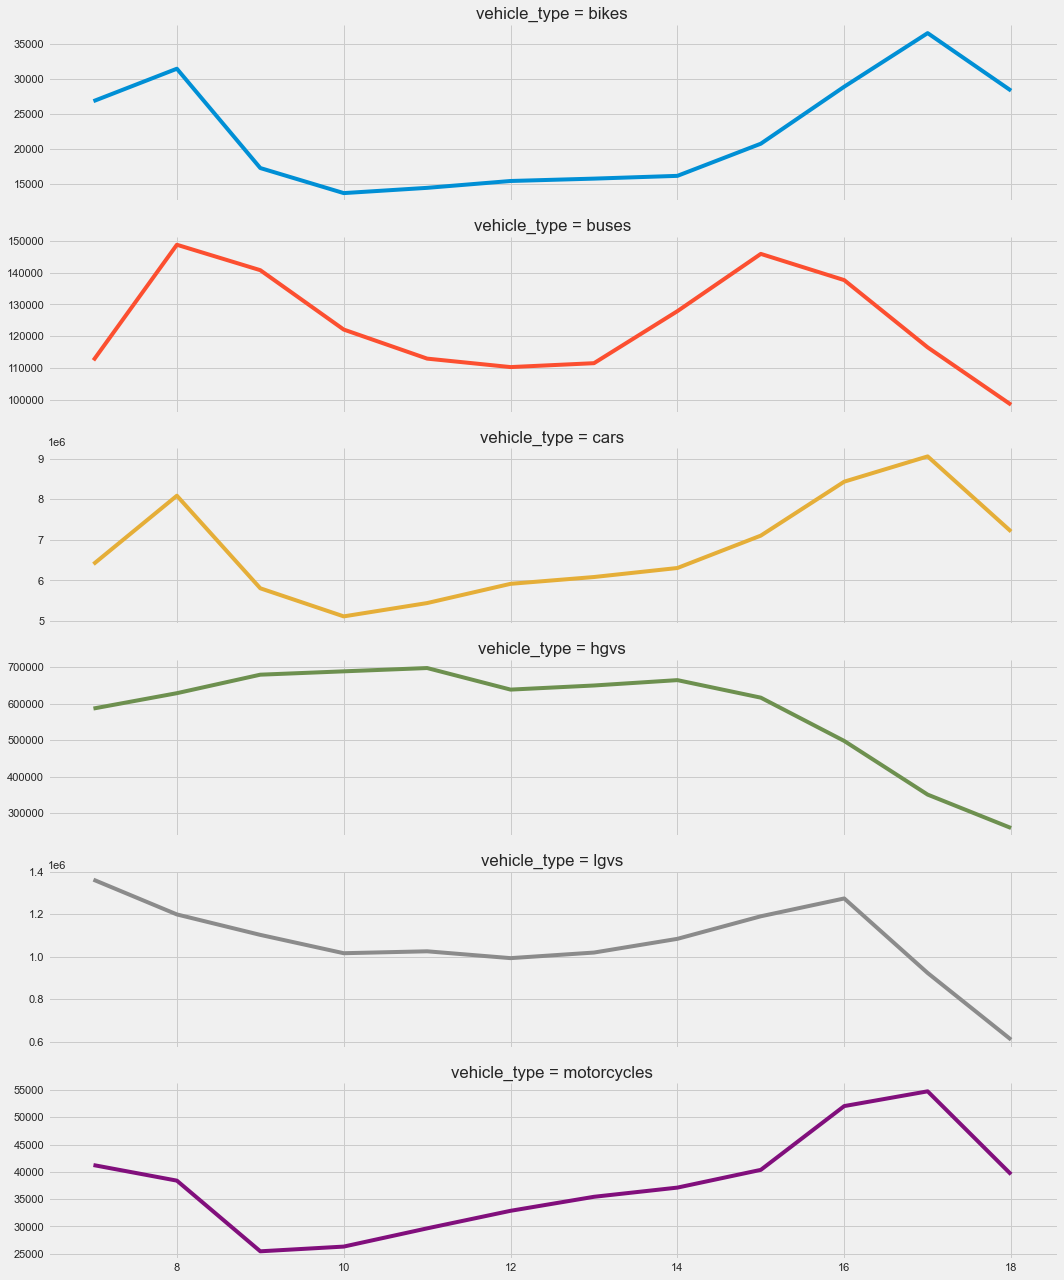

In [74]:
sns.set_theme()
plt.style.use('fivethirtyeight')
g = sns.FacetGrid(data=tod_df, col='vehicle_type', height=3, col_wrap=1, 
                  sharex=True, sharey=False, aspect=5)
g = g.map_dataframe(sns.lineplot, x='hour', y='value', hue ='vehicle_type')

In [85]:
x = tod_df.hour.unique()
y1 = tod_df.loc[tod_df.vehicle_type=='cars']['value']
y2 = tod_df.loc[tod_df.vehicle_type=='lgvs']['value']
y3 = tod_df.loc[tod_df.vehicle_type=='hgvs']['value']
y4 = tod_df.loc[tod_df.vehicle_type=='buses']['value']
y5 = tod_df.loc[tod_df.vehicle_type=='motorcycles']['value']
y6 = tod_df.loc[tod_df.vehicle_type=='bikes']['value']
y = [y1, y2, y3, y4, y5, y6]

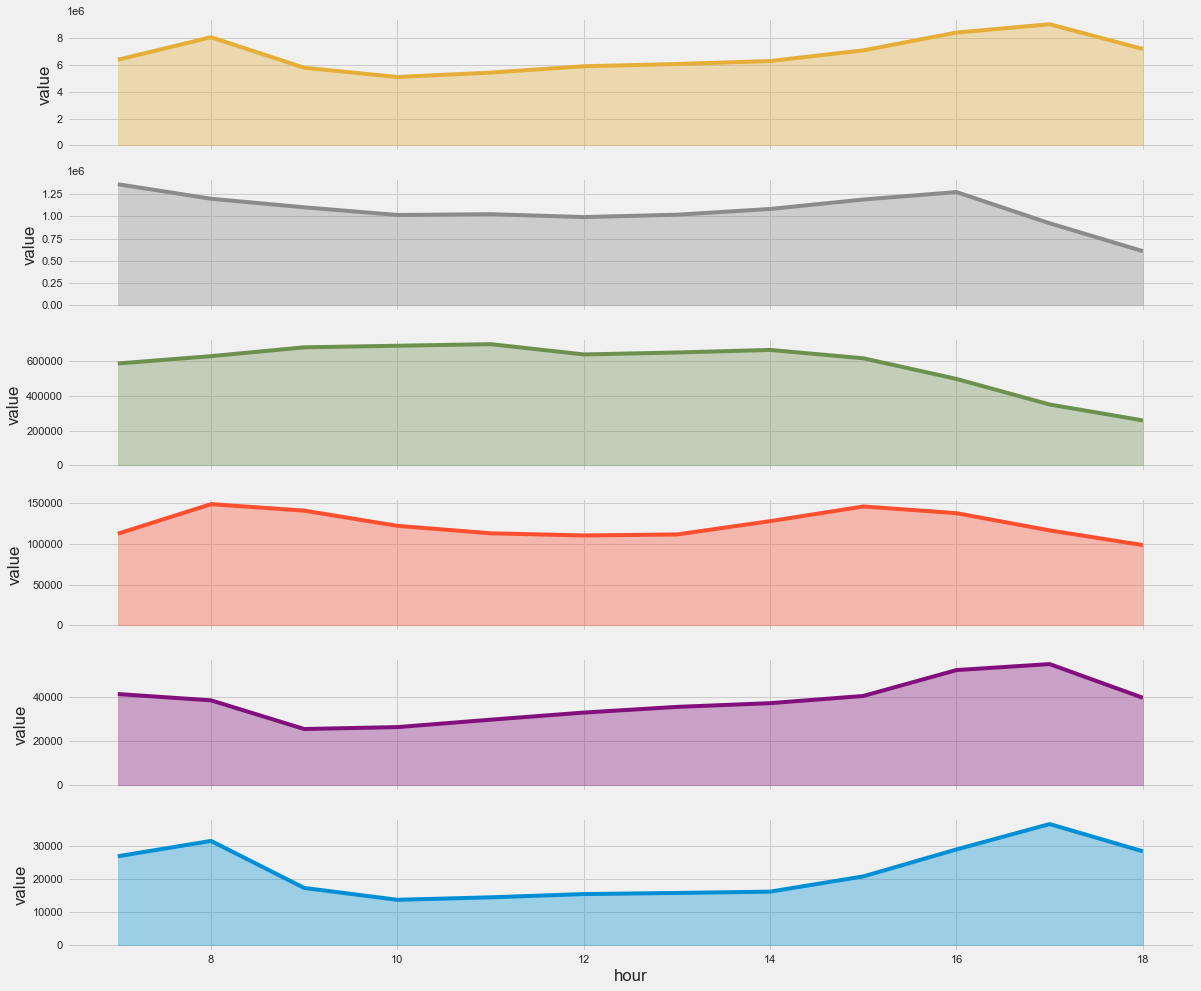

In [115]:
fig, axes = plt.subplots(6, 1, sharex=True, sharey=False, figsize=(18, 16))
hues = ['#e5ae38', '#8b8b8b', '#6d904f', '#fc4f30', '#810f7c', '#008fd5']
for i, ax in enumerate(axes):
    sns.lineplot(data=tod_df, x='hour', y=y[i], ax=ax, hue='vehicle_type')
    ax.fill_between(x, y[i], color=hues[i], alpha=0.35)
    ax.get_legend().remove()

# Q5: Bikes per capita per local authority 

### Caveats
1. Count data of bikes is assumed to be representative of the prevalence of bikes in the authority
2. A bike count within a local authority maps to that bike actually belonging to that authority
3. Double counting effects are ignored

This is because bikes are not registered vehicles and hence this assumption has to be made. We think this is a reasonable assumption since bikes are used for micro-mobility in the majority of cases.

### Outcome
* Horizontal bar chart ordered in descending order

### Method
* Get population data and store in tidy dataframe
* Plot the data

